In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import utils.tavr_torch as tavr_torch
from utils.tavr_torch import TAVR_3_Frame, TAVR_1_Frame, TAVR_Sequence, tavr_dataloader
from utils.visualization import display_grid, z_stretch, visualize_frame, set_figsize, get_central_slices
from utils.loss_functions import batch_l2_loss
from utils.run_model import train, test, save, load, get_loss_history
from Models.basic_models import average_model, two_layer_basic, post_process

set_figsize(20, 15)

Training directory found, 36 series
Validation directory found, 6 series
Testing directory found, 10 series


In [2]:
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

# "Pixl", "Slice", or "None"
preproc_type = "pixel"

validation = TAVR_3_Frame("__valid", preproc=preproc_type)
val_loader = tavr_dataloader(validation, batch_size=4, shuffle=True, num_workers=2)
training = TAVR_3_Frame("__train", preproc=preproc_type)
train_loader = tavr_dataloader(training,batch_size=8, shuffle=True, num_workers=2)


ave_model = average_model()
model = two_layer_basic()
post_proc = post_process(kind=preproc_type).to(device=device)
loss_fn = batch_l2_loss()

# CHANGE TO NAME OF JUPYTER NOTEBOOK
model_name = "Model 4 (Basic+PixelNorm) Run 1"

using device: cpu


In [3]:
learning_rate = 3e-3
momentum = 0.90
reg = 1e-7

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg, nesterov=True)

In [4]:
# Run cell to load model
LOAD = True
iteration_num = 81

if LOAD:
    
    load(model_name, iteration_num, model, optimizer)
    loss_history = get_loss_history(model_name)
    model.to(device=device)
else:
    loss_history = None

model loaded from model_checkpoints/Model 4 (Basic+PixelNorm) Run 1/Model 4 (Basic+PixelNorm) Run 1-81


In [5]:
train(model, post_proc, optimizer, train_loader, val_loader, loss_fn, device, 
         model_name, loss_history, epochs=3, print_every=30, print_level=3, lr_decay=1)

... ... ... 
Iteration 90, loss = 0.1647, corrected loss = 76.6546
Validation loss 71.4699 over 81 frames
model saved to model_checkpoints/Model 4 (Basic+PixelNorm) Run 1/Model 4 (Basic+PixelNorm) Run 1-90
conv_a1.weight,   	norm: 4.0530e+00, 	update norm: 1.7070e-03 	Update/norm: 4.2119e-04
conv_a1.bias,   	norm: 2.0996e-01, 	update norm: 1.8322e-04 	Update/norm: 8.7261e-04
conv_b1.weight,   	norm: 4.0069e+00, 	update norm: 2.6882e-03 	Update/norm: 6.7089e-04
conv_b1.bias,   	norm: 2.4603e-01, 	update norm: 4.3541e-04 	Update/norm: 1.7698e-03
final.weight,   	norm: 1.2751e+00, 	update norm: 2.1238e-03 	Update/norm: 1.6656e-03
final.bias,   	norm: 2.3121e-02, 	update norm: 2.2361e-04 	Update/norm: 9.6712e-03

... ... ... 
Iter 100... ... ... 
Iter 110... ... ... 
Iteration 120, loss = 0.1546, corrected loss = 71.9583
Validation loss 67.0581 over 81 frames
model saved to model_checkpoints/Model 4 (Basic+PixelNorm) Run 1/Model 4 (Basic+PixelNorm) Run 1-120
conv_a1.weight,   	norm: 4.0515

Process Process-17:
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Process Process-18:
KeyboardIn

KeyboardInterrupt: 

In [8]:
val_seq[0][0][None,:].shape

torch.Size([1, 77, 256, 256])

In [ ]:
# One last test + visualize results on 1 validation sequence
val_seq = TAVR_Sequence("__valid")
test(model, post_proc, val_loader, loss_fn, device)
test(ave_model, post_proc, val_loader, loss_fn, device)

/home/shared/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


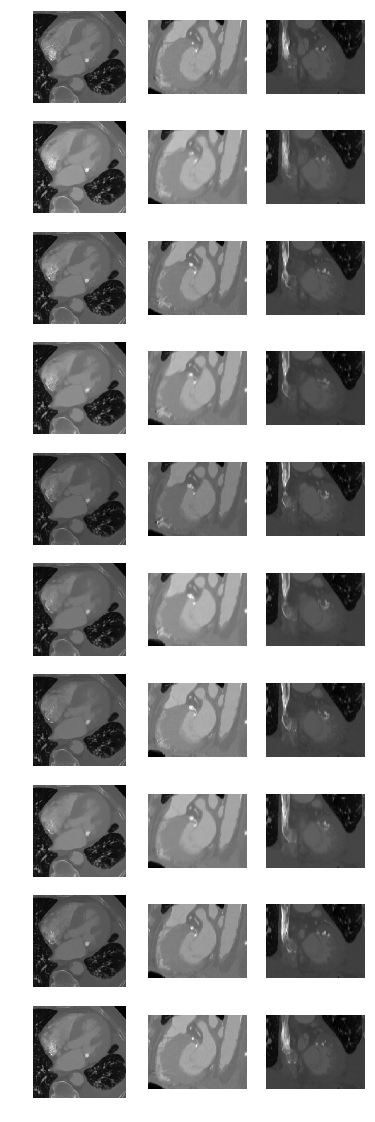

In [12]:
val_seq = TAVR_Sequence("__valid")
with torch.no_grad():
    model.eval()
    ave_frames = [post_proc(val_seq[0][0])]
    for i in range(2,9,2):
        ave_frame = model((val_seq[0][i-2][None,:], val_seq[0][i][None,:]))
        ave_frames += [post_proc(ave_frame[0][0]),  post_proc(val_seq[0][i])]
    ave_frames += [post_proc(val_seq[0][9])]
    ave_frames_slices = []
    for f in ave_frames:
        ave_frames_slices += get_central_slices(f)
    set_figsize(6,20)
    display_grid(10, 3, ave_frames_slices)

In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
for p in model.parameters():
    print(p.norm())